# Imports

In [172]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

# Exploratory Data Analysis

In [173]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

combined = pd.concat([train, test], ignore_index=True)

combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Descriptions of each of the columns/features:
- `survival`	Survival	0 = No, 1 = Yes
- `pclass`	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd
- `sex`	Sex	
- `Age`	Age in years	
- `sibsp`	# of siblings / spouses aboard the Titanic	
- `parch`	# of parents / children aboard the Titanic	
- `ticket`	Ticket number	
- `fare`	Passenger fare	
- `cabin`	Cabin number	
- `embarked`	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton

Preview Data Info

Seeing a lot of nulls in the cabin; perhaps it may make sense to drop the cabin column as a whole as noting the format of the data it seems difficult to parse/extract valuable information
Age, Embarked, and Fare do have some nulls, but they should be able to be filled in

In [174]:
print(combined.info())

print(combined.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB
None
       PassengerId    Survived       Pclass          Age        SibSp  \
count  1309.000000  891.000000  1309.000000  1046.000000  1309.000000   
mean    655.000000    0.383838     2.294882    29.881138     0.498854   
std     378.02006

Understand train and test split difference

In [175]:
print(train.info())

print(train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.48659

Survived is missing from test which makes sense, as that is what we are trying to predict; typically the answers in the form of the gender_submission.csv is what needs to be uploaded to Kaggle

In all the plots below that include "Survived", note that it is only using the train data as that is what we have; cross-validation will also only the train data as the correct answers (in the form of survived) are needed for each fold 

In [176]:
print(test.info())

print(test.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB
None
       PassengerId      Pclass         Age       SibSp       Parch        Fare
count   418.000000  418.000000  332.000000  418.000000  418.000000  417.000000
mean   1100.500000    2.265550   30.272590    0.447368    0.392344   35.627188
std     120.810458    0.841838   14.181209  

Count Number of Unique Values in the Ticket and Cabin columns

There does seem to be some common values but they tend to be generally unique

In [177]:
print(combined.Ticket.value_counts())
print(combined.Cabin.value_counts())

Ticket
CA. 2343        11
CA 2144          8
1601             8
PC 17608         7
S.O.C. 14879     7
                ..
113792           1
36209            1
323592           1
315089           1
359309           1
Name: count, Length: 929, dtype: int64
Cabin
C23 C25 C27        6
G6                 5
B57 B59 B63 B66    5
C22 C26            4
F33                4
                  ..
A14                1
E63                1
E12                1
E38                1
C105               1
Name: count, Length: 186, dtype: int64


Histograms of the Categorical Variables

Seems to be a strong right skew in SibSp, Fare, and Parch and a moderate right skew in Age

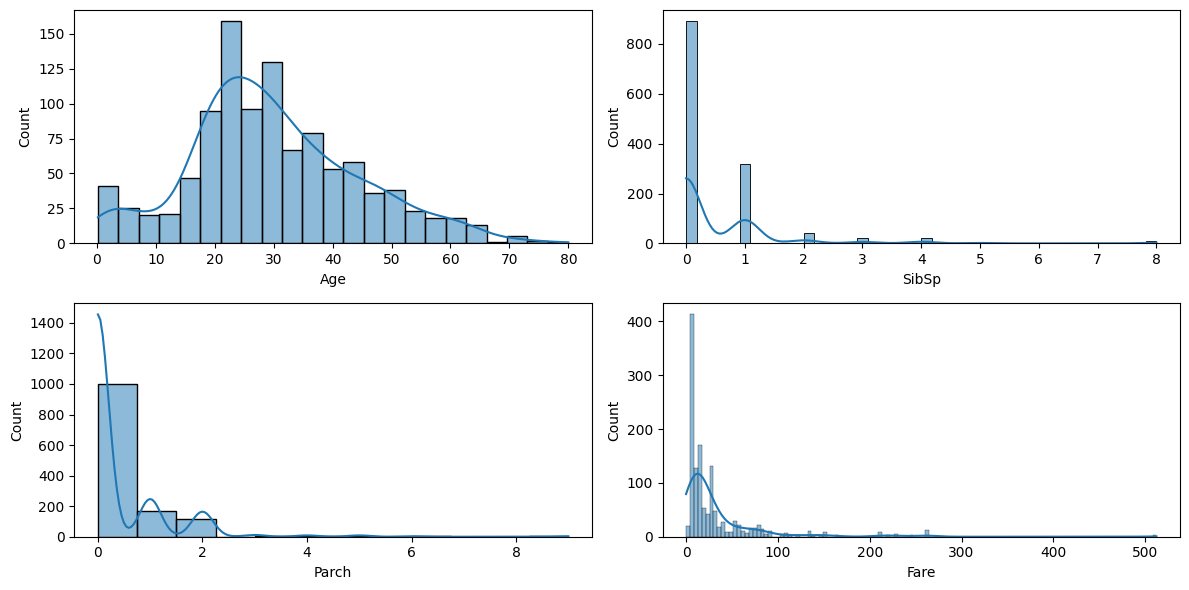

In [178]:
plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
sns.histplot(combined.Age, kde=True)

plt.subplot(2, 2, 2)
sns.histplot(combined.SibSp, kde=True)

plt.subplot(2, 2, 3)
sns.histplot(combined.Parch, kde=True)

plt.subplot(2, 2, 4)
sns.histplot(combined.Fare, kde=True)

plt.tight_layout()

Countplots of the Categorical Variables (excluding Names, PassengerID, and Name)

Although there is an imbalance between the different classes for each of the below categorical variables, there still should be enough data to train off of as the smallest class of "Q" in the feature Embarked is still ~100 data points.

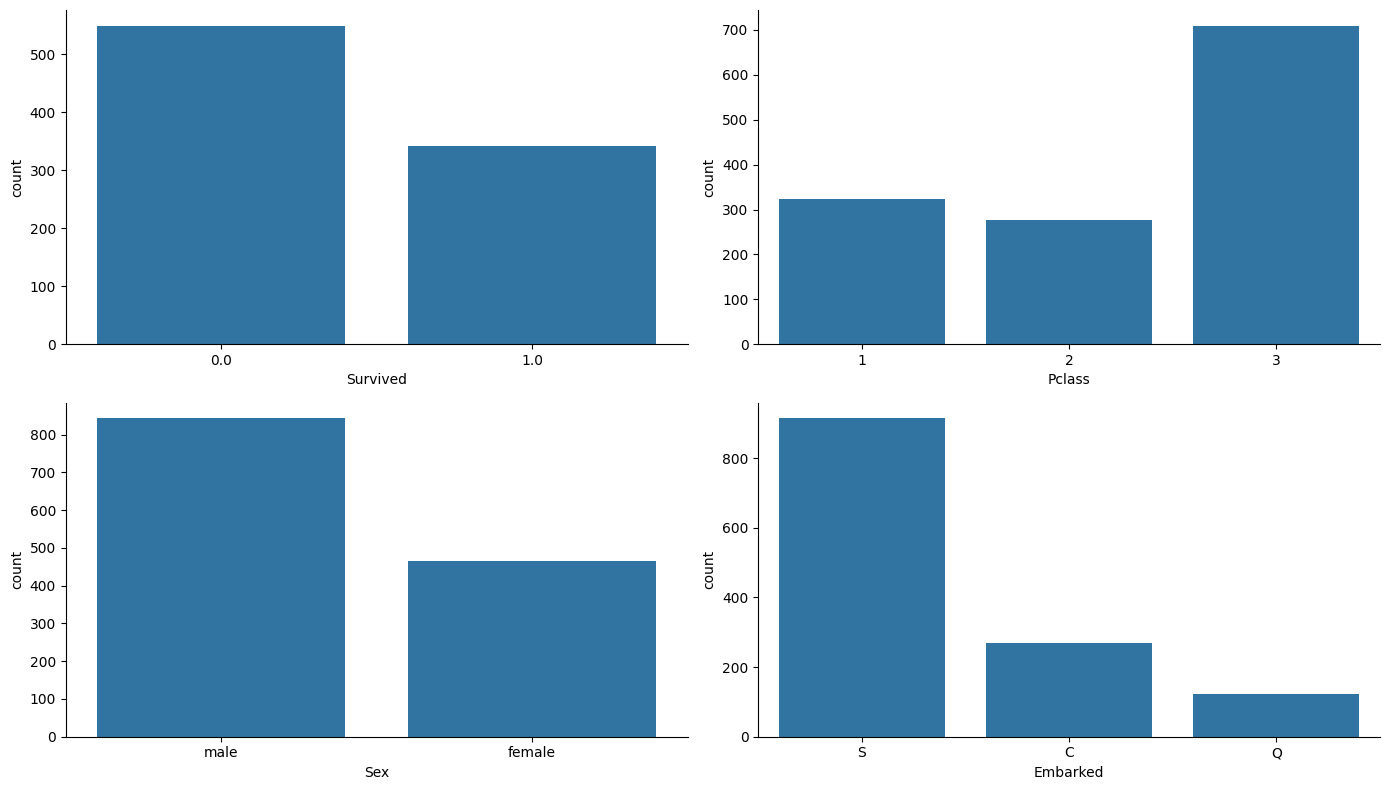

In [179]:
plt.figure(figsize=(14, 8))

plt.subplot(2, 2, 1)
sns.countplot(x="Survived", data=combined)

plt.subplot(2, 2, 2)
sns.countplot(x="Pclass", data=combined)

plt.subplot(2, 2, 3)
sns.countplot(x="Sex", data=combined)

plt.subplot(2, 2, 4)
sns.countplot(x="Embarked", data=combined)

plt.tight_layout()
sns.despine()

Pairplot of the whole data frame to get an idea for the relationships between variables

I'm not noticing a whole lot of linear relationships/obvious classifications or separations of data points from these scatterplots, suggesting the relationship between the features is perhaps more complex.

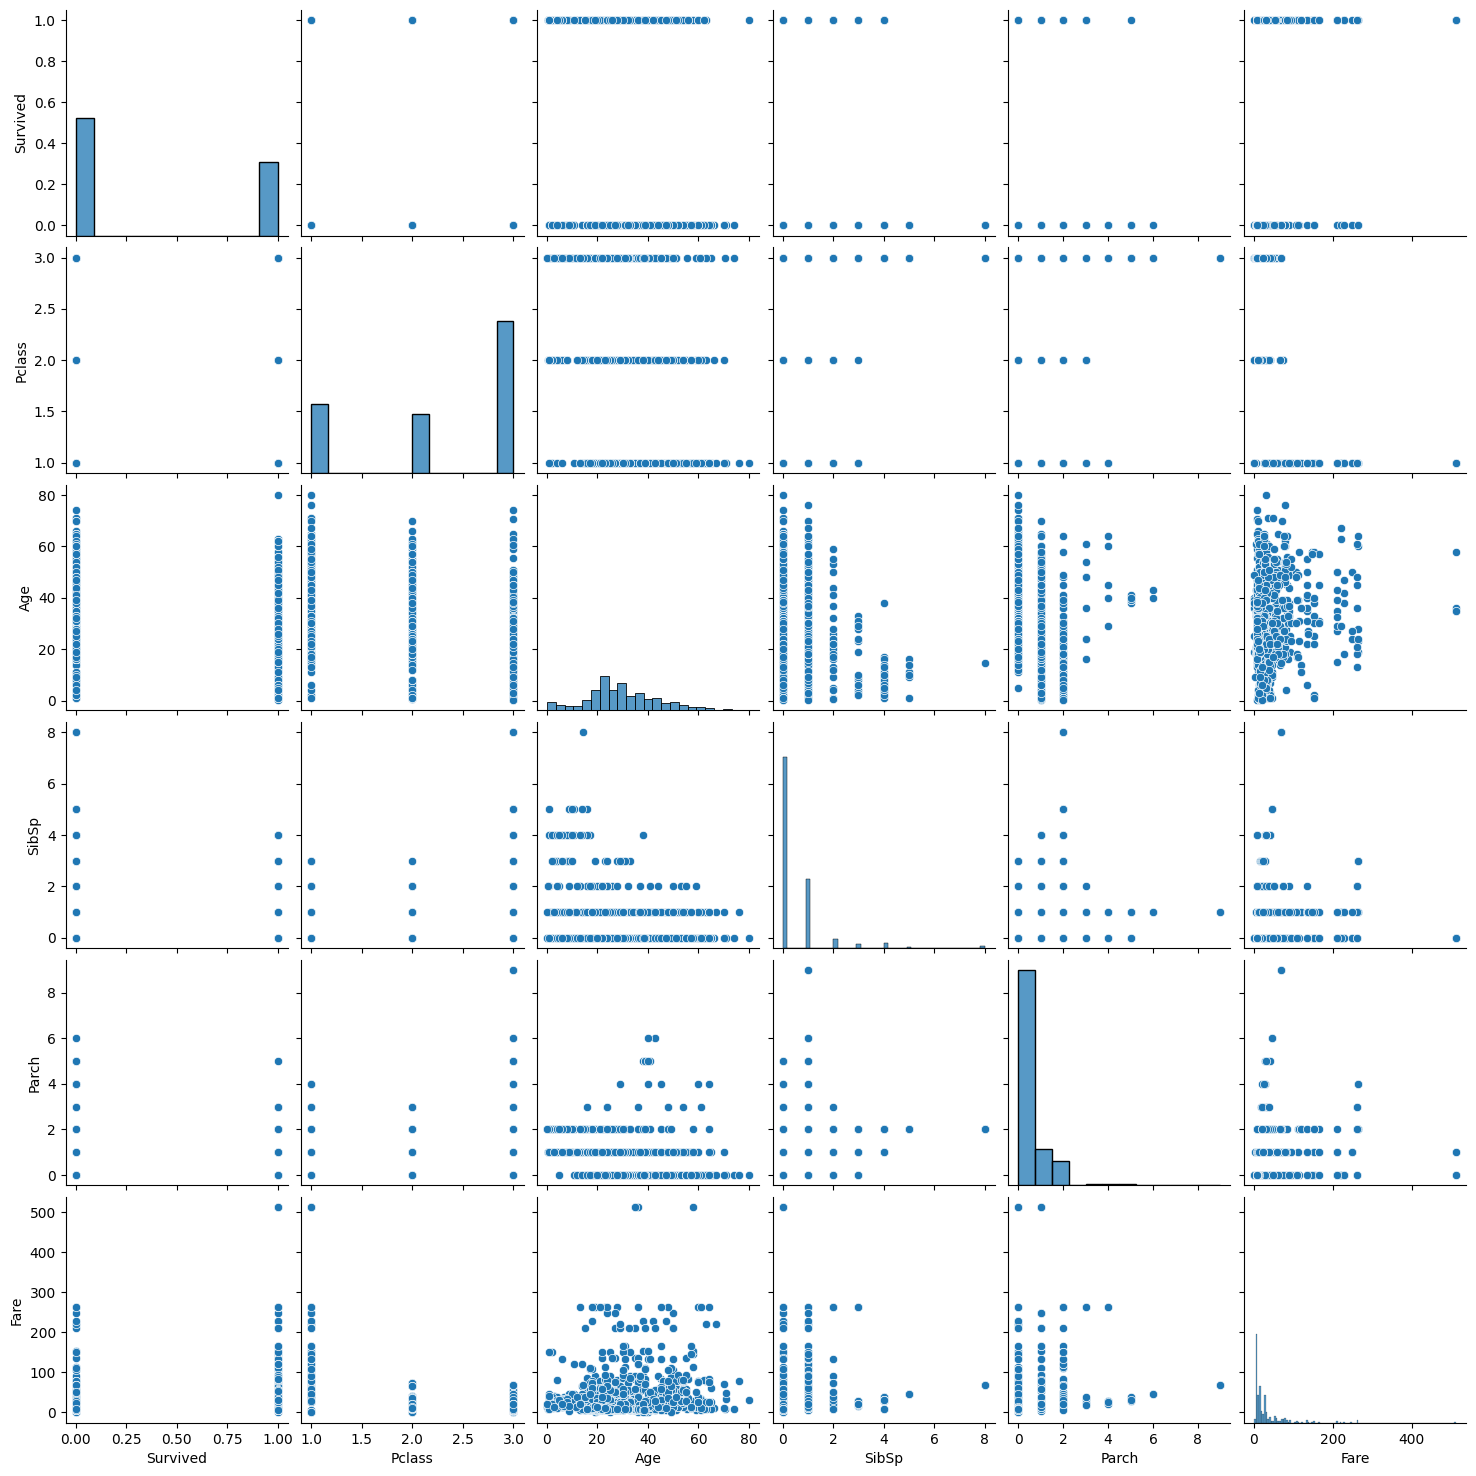

In [180]:
sns.pairplot(combined.drop(columns=["PassengerId"]))

Correlation Matrix

This confirmed what we saw earlier in the scatterplots. Parch and SibSp are slightly correlated which makes sense as the more parents/children you have the larger your family is typically and so you might be more likely to have more siblings.

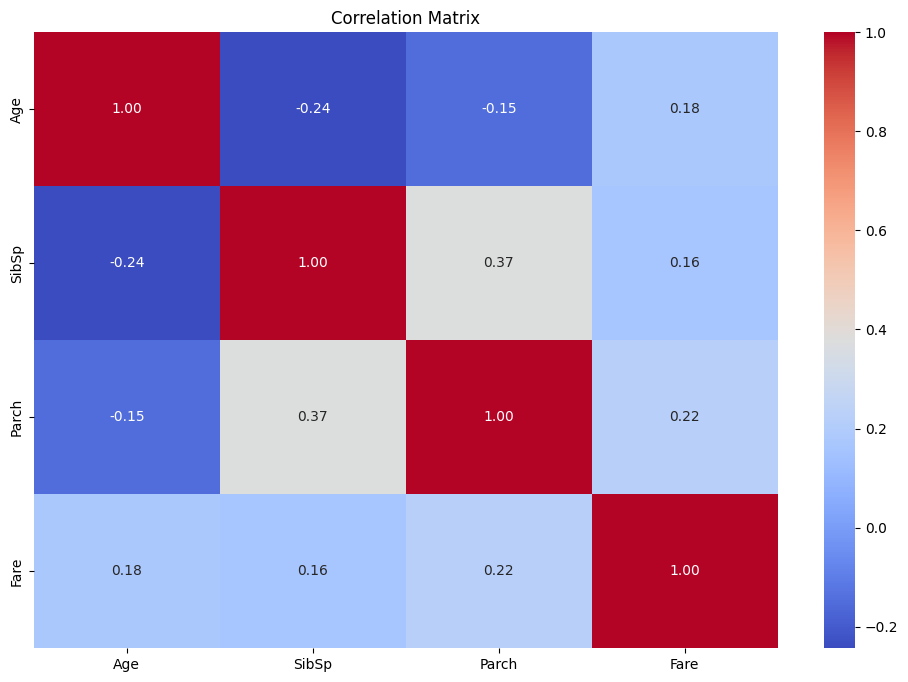

In [181]:
corr = combined.drop(columns=["PassengerId", "Name", "Pclass", "Survived", "Sex", "Ticket", "Cabin", "Embarked"]).corr()

fig, ax = plt.subplots(1,1, figsize=(12,8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", ax=ax)
plt.title("Correlation Matrix")
plt.show()

# Data Pre-Processing

Drop columns

Dropping the
- Name column because the name of the passenger provides no useful information to the model
- Cabin column because there a lot of nulls present and the cabin information that is present has some information but is difficult to parse and extract useful information from
- PassengerId column because that just numbers the entries in the dataset
- Ticket column as that has practically unique tickets for each entry in the dataset

In [182]:
train.drop(columns=["Name", "Cabin", "PassengerId", "Ticket"], inplace=True)

train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [183]:
test.drop(columns=["Name", "Cabin", "PassengerId", "Ticket"], inplace=True)

test.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,male,34.5,0,0,7.8292,Q
1,3,female,47.0,1,0,7.0000,S
2,2,male,62.0,0,0,9.6875,Q
3,3,male,27.0,0,0,8.6625,S
4,3,female,22.0,1,1,12.2875,S


Separate y_train

In [184]:
y_train = train.Survived

train.drop(columns=["Survived"], inplace=True)

y_train.head()

0    0
1    1
2    1
3    1
4    0
Name: Survived, dtype: int64

Fill in all nulls

- Age with the mean age
- Embarked with the most common class
- Fare with the mean fare

In [185]:
# before
print(train.isnull().sum())
print(test.isnull().sum())

train.Age = train.Age.fillna(train.Age.mean())
train.Embarked = train.Embarked.fillna(train.Embarked.mode()[0])

test.Age = test.Age.fillna(test.Age.mean())
test.Fare = test.Fare.fillna(test.Fare.mean())


# after
print(train.isnull().sum())
print(test.isnull().sum())

# median_age = df.age.median()
# mode_embarked = df.embarked.mode()

# df.age = df.age.fillna(median_age)
# df.embarked = df.embarked.fillna(mode_embarked[0])

# df.head()

Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64
Pclass       0
Sex          0
Age         86
SibSp        0
Parch        0
Fare         1
Embarked     0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


Need to standardize the data as there is skew present in some of the quantative variables; this will aid in the end prediction for the classifers

In [186]:
scaler = StandardScaler()

# X_train_scaled = scaler.fit_transform(train)
# X_test_scaled = scaler.transform(test)

# have to seperate out the train numerical versus the categorical because it was throwing errors
X_train_numerical = train.drop(columns=["Pclass", "Sex", "Embarked"])
X_train_numerical_scaled = pd.DataFrame(scaler.fit_transform(X_train_numerical), columns=X_train_numerical.columns, index=train.index)

X_test_numerical = test.drop(columns=["Pclass", "Sex", "Embarked"])
X_test_numerical_scaled = pd.DataFrame(scaler.transform(X_test_numerical), columns=X_test_numerical.columns, index=test.index)

X_train_categorical = train[["Pclass", "Sex", "Embarked"]].reset_index(drop=True)
X_test_categorical = test[["Pclass", "Sex", "Embarked"]].reset_index(drop=True)

# need axis=1 for it to go row by row
X_train_scaled = pd.concat([X_train_numerical_scaled.reset_index(drop=True), X_train_categorical], axis=1)
X_test_scaled = pd.concat([X_test_numerical_scaled.reset_index(drop=True), X_test_categorical], axis=1)

X_train_scaled.describe()

,Age,SibSp,Parch,Fare,Pclass
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,891.000000
mean,2.232906e-16,4.386066e-17,5.382900e-17,3.987333e-18,2.308642
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,0.836071
min,-2.253155e+00,-4.745452e-01,-4.736736e-01,-6.484217e-01,1.000000
25%,-5.924806e-01,-4.745452e-01,-4.736736e-01,-4.891482e-01,2.000000
50%,0.000000e+00,-4.745452e-01,-4.736736e-01,-3.573909e-01,3.000000
75%,4.079260e-01,4.327934e-01,-4.736736e-01,-2.424635e-02,3.000000
max,3.870872e+00,6.784163e+00,6.974147e+00,9.667167e+00,3.000000


In [187]:
X_train_scaled.head()

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,-0.592481,0.432793,-0.473674,-0.502445,3,male,S
1,0.638789,0.432793,-0.473674,0.786845,1,female,C
2,-0.284663,-0.474545,-0.473674,-0.488854,3,female,S
3,0.407926,0.432793,-0.473674,0.420730,1,female,S
4,0.407926,-0.474545,-0.473674,-0.486337,3,male,S


In [188]:
X_test_scaled.head()

,Age,SibSp,Parch,Fare,Pclass,Sex,Embarked
0,0.369449,-0.474545,-0.473674,-0.490783,3,male,Q
1,1.331378,0.432793,-0.473674,-0.507479,3,female,S
2,2.485693,-0.474545,-0.473674,-0.453367,2,male,Q
3,-0.207709,-0.474545,-0.473674,-0.474005,3,male,S
4,-0.592481,0.432793,0.767630,-0.401017,3,female,S


Use one-hot encoding to convert categorical data to data that the models can process

In [190]:
X_train_scaled = pd.get_dummies(X_train_scaled, drop_first=True, dtype="int64")
X_test_scaled = pd.get_dummies(X_test_scaled, drop_first=True, dtype="int64")

In [191]:
X_train_scaled.head()

,Age,SibSp,Parch,Fare,Pclass,Sex_male,Embarked_Q,Embarked_S
0,-0.592481,0.432793,-0.473674,-0.502445,3,1,0,1
1,0.638789,0.432793,-0.473674,0.786845,1,0,0,0
2,-0.284663,-0.474545,-0.473674,-0.488854,3,0,0,1
3,0.407926,0.432793,-0.473674,0.420730,1,0,0,1
4,0.407926,-0.474545,-0.473674,-0.486337,3,1,0,1


In [192]:
X_test_scaled.head()

,Age,SibSp,Parch,Fare,Pclass,Sex_male,Embarked_Q,Embarked_S
0,0.369449,-0.474545,-0.473674,-0.490783,3,1,1,0
1,1.331378,0.432793,-0.473674,-0.507479,3,0,0,1
2,2.485693,-0.474545,-0.473674,-0.453367,2,1,1,0
3,-0.207709,-0.474545,-0.473674,-0.474005,3,1,0,1
4,-0.592481,0.432793,0.767630,-0.401017,3,0,0,1


# Evaluate Classifiers Using Cross Validation

The classifiers that were chosen to be evaluated were:

- Logistic Regression
- Decision Tree Classifier
- Bagging Classifier
- AdaBoost Classifier
- Random Forest Classifier
- Support Vector Machine
- Multilayer Perceptron Classifier

This was primarily because these are the machine learning techniques I was familiar with and that we learned in the course. Optimally, we are going to select the classifier that has the highest mean accuracy during cross validation with 10 folds and then tune hyperparameters from there.

Define models list

In [193]:
models = []

Append candidate models to the models list

These models have practically default settings

In [194]:
models.append(("Logistic Regression", LogisticRegression(max_iter=1000)))

models.append(("Decision Tree Classifier", DecisionTreeClassifier(random_state=0)))
              
models.append(("Bagging Classifier", BaggingClassifier(DecisionTreeClassifier(random_state=42), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=0)))

models.append(("AdaBoost Classifier", AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm="SAMME", learning_rate=0.5, random_state=0)))

models.append(("Random Forest Classifier", RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=0)))
              
svc = SVC(kernel = 'rbf', degree = 2, C=1, random_state=0, max_iter = 1000000)
models.append(("Support Vector Machine Classifier", OneVsRestClassifier(svc)))

models.append(("Multilayer Perceptron Classifier", MLPClassifier(random_state=1, max_iter=300)))

Now do 10 K-Folds Cross Validation

In [195]:
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, random_state=0, shuffle = True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

Logistic Regression: 0.800212 (0.021299)
Decision Tree Classifier: 0.780037 (0.024045)
Bagging Classifier: 0.818177 (0.020005)
AdaBoost Classifier: 0.809176 (0.019032)
Random Forest Classifier: 0.823795 (0.021909)
Support Vector Machine Classifier: 0.824919 (0.022552)
Multilayer Perceptron Classifier: 0.815980 (0.020363)


# Plot & Interpret Results of Cross Validation

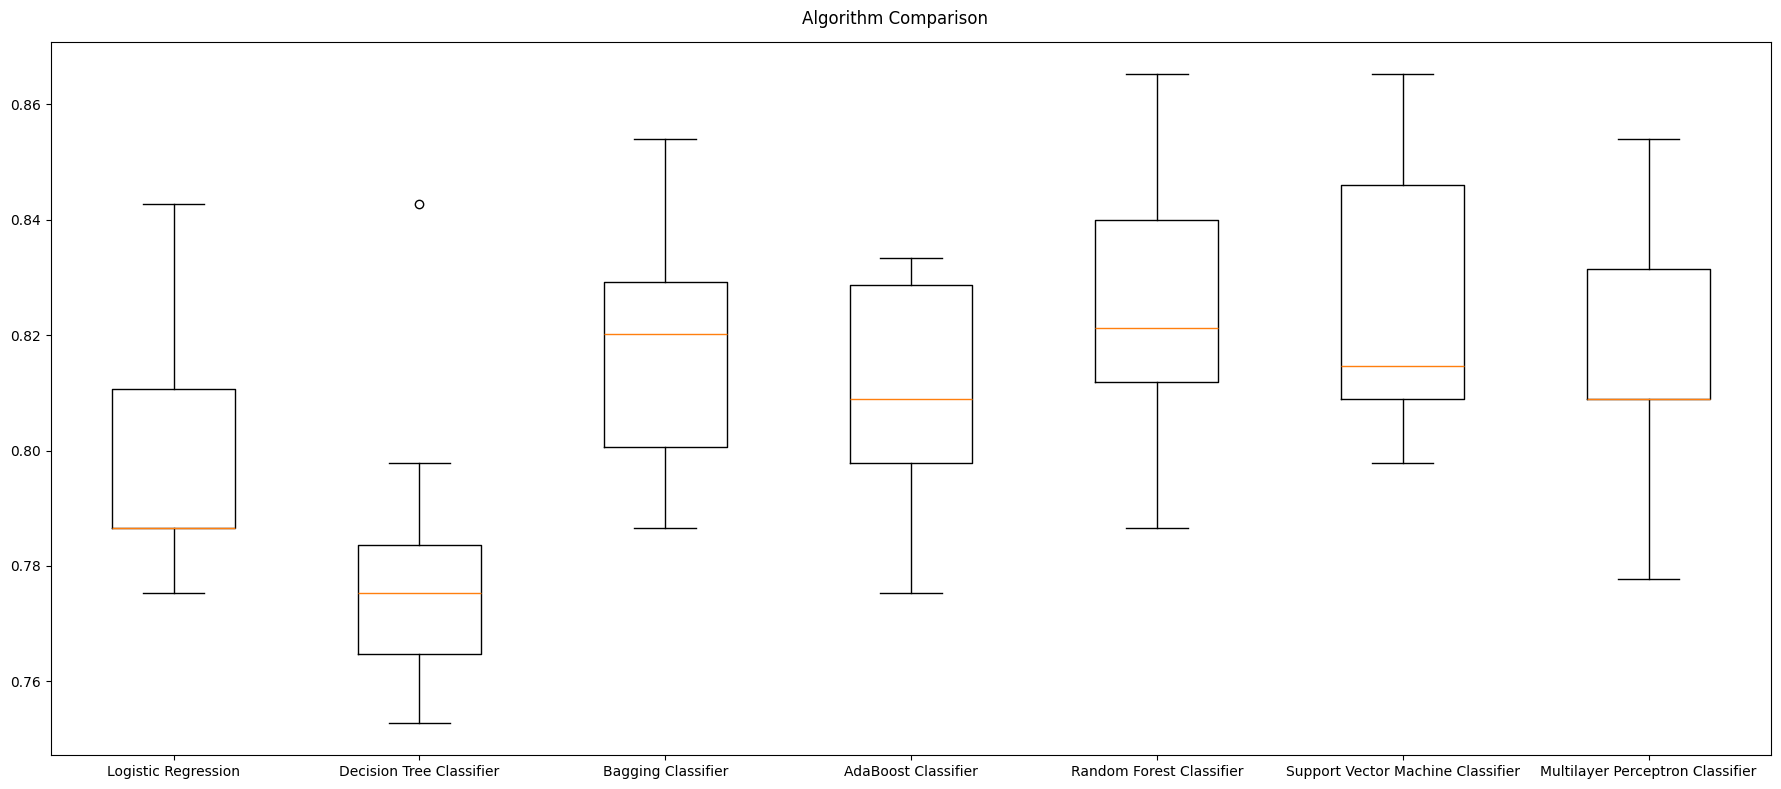

In [196]:
fig = plt.figure(figsize=(18, 8))
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.tight_layout()
plt.show()

The best classifier seems to be the Random Forest Classifier as it has the highest mean accuracy of 0.827154 with a standard deviation of 0.022628. The 2nd best classifier was the Support Vector Machine classifier with a mean accuracy of 0.824906 and a standard deviation 0.019663. The 3rd best classifier was the Bagging Classifier with a mean accuracy of 0.824906 and a standard deviation of 0.020295.

# Tune Hyperparameters

I will be trying to tune the hyperparameters for the random forest classifier. A lot of users used the random forest classifier in their submissions, suggesting that the random forest classifier is perhaps the best model for this task.

I found a submission that used some type of random search cv to tune hyperparameters (https://www.kaggle.com/code/javierph/titanic-from-feature-engineering-to-final-model). I plan on using the in built RandomizedSearchCV from sklearn as it is more efficient. 

See this article for a description of each of the possible hyperparameters: https://www.geeksforgeeks.org/hyperparameters-of-random-forest-classifier/.

In [202]:
rf = RandomForestClassifier(random_state=0)

params = {
    'n_estimators': [200, 400, 600, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [1, 2, 4, 8],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30],
    'max_samples': [0.25, 0.5, 0.75, 1.0],   
}


random_search_cv = RandomizedSearchCV(estimator=rf, param_distributions=params, n_iter=50,cv=5, scoring='accuracy', random_state=0, n_jobs=-1)

random_search_cv.fit(X_train_scaled, y_train)

random_search_cv.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_samples': 0.75,
 'max_leaf_nodes': 30,
 'max_features': 'log2',
 'max_depth': None}

# Display Final Model Accuracy with Cross Validation

Define Best Model

In [203]:
rf_final = RandomForestClassifier(
    n_estimators=800,
    min_samples_split=2,
    min_samples_leaf=1,
    max_samples=0.75,
    max_leaf_nodes=30,
    max_features='log2',
    max_depth=None,
    random_state=0,
)

Test it on the K-Folds Cross Validation we did earlier and plot results

In [204]:
results = []
names = []
scoring = 'accuracy'

kfold = KFold(n_splits=10, random_state=0, shuffle = True)
cv_results = cross_val_score(rf_final, X_train_scaled, y_train, cv=kfold, scoring=scoring)
results.append(cv_results)
msg = "%s: %f (%f)" % ("Final Random Forest Classifier", cv_results.mean(), cv_results.std())
print(msg)

Final Random Forest Classifier: 0.830524 (0.022740)


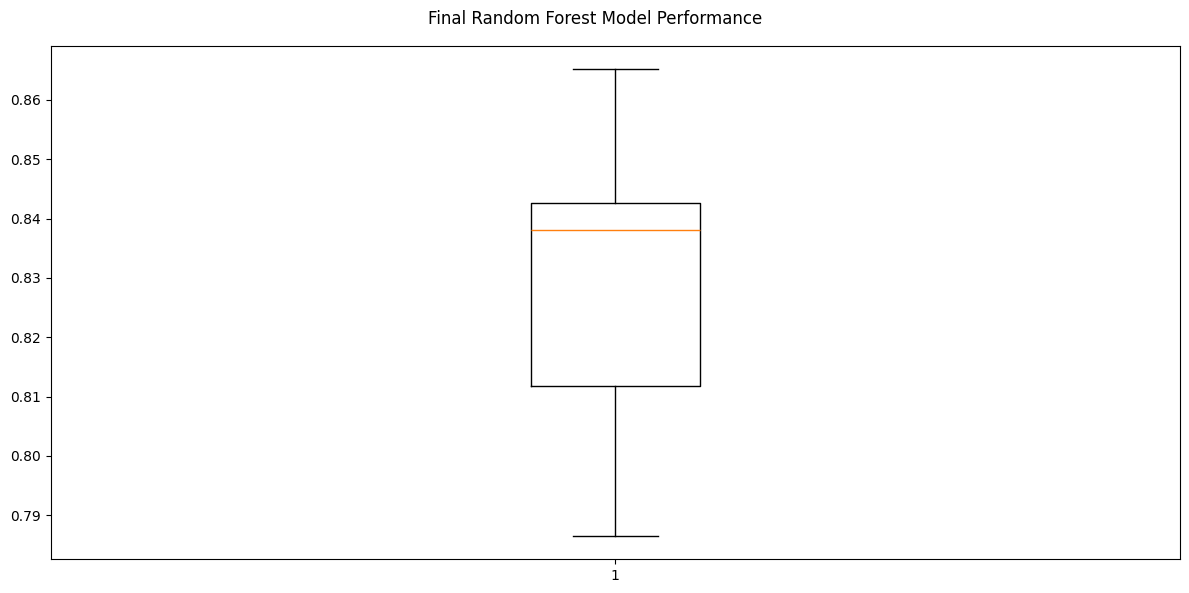

In [205]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle('Final Random Forest Model Performance')
ax = fig.add_subplot(111)
plt.boxplot(results)
plt.tight_layout()
plt.show()

The model did improve slightly from 0.827154 mean accuracy to 0.830524. I think this is because number of estimators is just increasing; however, it's relatively clear that the performance that comes from increasing the number of estimators is beginning to taper off.

# Kaggle Submission 

Fit and Output the Data for Kaggle Submission

In [206]:
rf_final.fit(X_train_scaled, y_train)

y_pred = rf_final.predict(X_test_scaled) 

y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [208]:
print(len(y_pred))

418


Convert y_pred array to the format of the submission and export it

In [207]:
passenger_id = pd.Series(range(892, 1310), name='PassengerId')

predictions = pd.DataFrame({
    'PassengerId': passenger_id,
    'Survived': y_pred
})

predictions.to_csv("predictions.csv", index=False)

Obtained a score of 0.78468

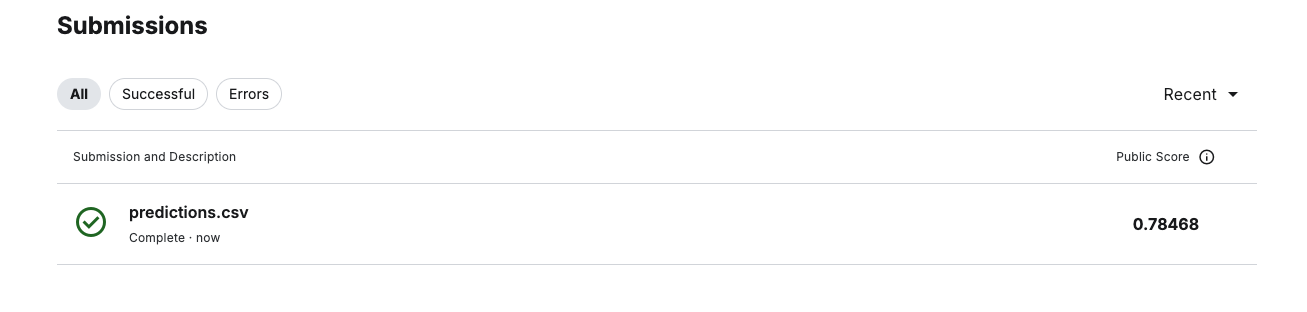